In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from collections import defaultdict
import numpy as np
from matplotlib.pyplot import plot,hist,bar,scatter

In [2]:
recipes = pd.read_csv('data/RAW_recipes.csv')
interactions = pd.read_csv('data/RAW_interactions.csv')

In [3]:
interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [4]:
np.random.seed(1)
interaction_array = interactions.to_numpy()
np.random.shuffle(interaction_array)
interaction_train = interaction_array[:len(interaction_array) * 8 // 10]
interaction_valid = interaction_array[len(interaction_array) * 8 // 10:len(interaction_array) * 9 // 10]
interaction_test = interaction_array[len(interaction_array) * 9 // 10:]

ratingsPerUser = defaultdict(list)
ratingsPerRecipe = defaultdict(list)
recipesPerUser = defaultdict(set)
usersPerRecipe = defaultdict(set)
all_ratings_per_pair = defaultdict(int)
for user_id, recipe_id, date, rating, review in interaction_train:
    ratingsPerUser[user_id].append((recipe_id,rating))
    ratingsPerRecipe[recipe_id].append((user_id,rating))
    recipesPerUser[user_id].add(recipe_id)
    usersPerRecipe[recipe_id].add(user_id)
    all_ratings_per_pair[(user_id,recipe_id)] = rating

In [5]:
# ratingsTrain = allRatings[:190000]
# ratingsValid = allRatings[190000:]
# ratingsPerUser = defaultdict(list)
# ratingsPerItem = defaultdict(list)
# itemsPerUser = defaultdict(set)
# usersPerItem = defaultdict(set)
# all_ratings_per_pair = defaultdict(int)
# for u,b,r in ratingsTrain:
#     ratingsPerUser[u].append((b,r))
#     ratingsPerItem[b].append((u,r))
#     itemsPerUser[u].add(b)
#     usersPerItem[b].add(u)
#     all_ratings_per_pair[(u,b)] = r

In [55]:
def train_latent_factor(reg, threshold):
    user_beta_param = defaultdict(int)
    recipe_beta_param = defaultdict(int)
    global_alpha = 0
    def calculate_mse(dataset):
        return np.mean([np.square(global_alpha + user_beta_param[user_id] + recipe_beta_param[recipe_id] - rating) for user_id, recipe_id, date, rating, review in dataset])
    def calculate_sse_reg(dataset, reg):
        reg_term = reg * (np.sum(np.square(list(recipe_beta_param.values()))) + np.sum(np.square(list(user_beta_param.values()))))
        return np.sum([np.square(global_alpha + user_beta_param[user_id] + recipe_beta_param[recipe_id] - rating) for user_id, recipe_id, date, rating, review in dataset]) + reg_term
    training_iteration = 0
    all_losses = []
    all_valid_mses = []
    prev_loss = float('inf')
    current_loss = calculate_sse_reg(interaction_train, reg)
    while np.abs(prev_loss - current_loss) > threshold:
        training_iteration += 1
        for recipe in ratingsPerRecipe:
            users_rating_for_this_recipe = ratingsPerRecipe[recipe] 
            reg_term = (reg + len(users_rating_for_this_recipe))
            recipe_beta_param[recipe] = np.sum([rating - (global_alpha + user_beta_param[user]) for user,rating in users_rating_for_this_recipe])/reg_term
        for user in ratingsPerUser:
            recipes_rating_for_this_user = ratingsPerUser[user] 
            reg_term = (reg + len(recipes_rating_for_this_user))
            user_beta_param[user] = np.sum([rating - (global_alpha + recipe_beta_param[recipe]) for recipe,rating in recipes_rating_for_this_user])/reg_term
        global_alpha = np.sum([all_ratings_per_pair[(user,recipe)] - (user_beta_param[user] + recipe_beta_param[recipe]) for user, recipe in all_ratings_per_pair]) / len(all_ratings_per_pair)
        prev_loss = current_loss
        current_loss = calculate_sse_reg(interaction_train, reg)
        valid_mse = calculate_mse(interaction_valid)
        all_losses.append(current_loss)
        all_valid_mses.append(valid_mse)
        if training_iteration % 5 == 1:
            print(f"Iteration {training_iteration}:")
            print(f"SSE Loss: {current_loss}")
            print(f"Valid MSE: {valid_mse}")
    return [global_alpha, user_beta_param, recipe_beta_param], training_iteration, all_losses, all_valid_mses

In [56]:
latent_factor_infos = []
reg_params = []
for reg_param in range(25,50,5):
    reg_param = reg_param / 10
    reg_params.append(reg_param)
    print(f"Reg Param: {reg_param}")
    latent_factor_infos.append(train_latent_factor(reg_param, 1000))
    print()
[x[-1][-1] for x in latent_factor_infos]

Reg Param: 2.5
Iteration 1:
SSE Loss: 4233501.717655072
Valid MSE: 3.012183452625178
Iteration 6:
SSE Loss: 1563273.0266886025
Valid MSE: 1.8965204279018224
Iteration 11:
SSE Loss: 1127214.0393039365
Valid MSE: 1.5485434153958948
Iteration 16:
SSE Loss: 994292.0075342997
Valid MSE: 1.4460280180900087
Iteration 21:
SSE Loss: 961933.638751481
Valid MSE: 1.4286149711305491

Reg Param: 3.0
Iteration 1:
SSE Loss: 4480432.577671228
Valid MSE: 3.0252189527515227
Iteration 6:
SSE Loss: 1567105.716484117
Valid MSE: 1.8496071111695445
Iteration 11:
SSE Loss: 1125715.016334013
Valid MSE: 1.5095013436262013
Iteration 16:
SSE Loss: 1014031.528723923
Valid MSE: 1.4320332960031255
Iteration 21:
SSE Loss: 991617.8316501476
Valid MSE: 1.423608756614058

Reg Param: 3.5
Iteration 1:
SSE Loss: 4680744.825050358
Valid MSE: 3.0400836324619753
Iteration 6:
SSE Loss: 1563448.0999027495
Valid MSE: 1.8081420284707415
Iteration 11:
SSE Loss: 1126124.1127629024
Valid MSE: 1.48276547761154
Iteration 16:
SSE Loss: 

[1.4283450485066866,
 1.4244431684470615,
 1.4215352684714353,
 1.4199220546082472,
 1.418888557027016]

In [6]:
all_mses = [x[-1][-1] for x in latent_factor_infos]
lamb = reg_params[np.argmin(all_mses)]
best_params, best_num_training_iteration, best_all_losses, best_all_valid_mses = latent_factor_infos[np.argmin(all_mses)]
validMSE = best_all_valid_mses[-1]

NameError: name 'latent_factor_infos' is not defined

In [58]:
def calculate_mse(dataset,alpha,user_beta,recipe_beta):
        return np.mean([np.square(alpha + user_beta[user_id] + recipe_beta[recipe_id] - rating) for user_id, recipe_id, date, rating, review in dataset])

In [59]:
predictions = []
best_alpha, best_user_beta_param, best_recipe_beta_param = best_params
calculate_mse(interaction_test,best_alpha, best_user_beta_param, best_recipe_beta_param)

1.4411919882421653

In [9]:
np.random.seed(1)
# np.random.shuffle(interactions)
interactions_train = interactions.iloc[:interactions.shape[0] * 8 // 10]
interactions_valid = interactions.iloc[interactions.shape[0] * 8 // 10:interactions.shape[0] * 9 // 10]
interactions_test = interactions.iloc[interactions.shape[0] * 9 // 10]


merged = interactions_train.merge(right=recipes,how='left',left_on='recipe_id',right_on='id')

merged = merged.drop(columns=['id','review','name','steps','description'])

merged = merged.astype({'date':'datetime64[us]','submitted':'datetime64[us]'})
merged['days_difference'] = (merged.date - merged.submitted).dt.days
unique_contributors = merged['contributor_id'].value_counts()


In [119]:
interactions_valid

,user_id,recipe_id,date,rating,review
905893,176615,83207,2009-10-11,5,Boy it just doesn't get any easier than this! ...
905894,531256,83207,2009-10-19,4,i just made this today and i thought it was gr...
905895,462997,83207,2009-10-25,5,Wow! This was delicious! I like it when I stum...
905896,34122,83207,2009-11-04,5,"This simple, quick recipe exceeds expectations..."
905897,930552,83207,2009-12-17,5,"This was delicious, and I wish I could give it..."
...,...,...,...,...,...
1019125,107135,136500,2006-05-07,5,iloved this for breakfast.dee
1019126,226863,136500,2008-12-14,5,"I made this for breakfast, cut down to one ser..."
1019127,166642,136500,2009-01-28,5,This is delcicious! Made this for me for break...
1019128,706608,260625,2008-05-08,5,Awesome! Only change i made was adding some ho...


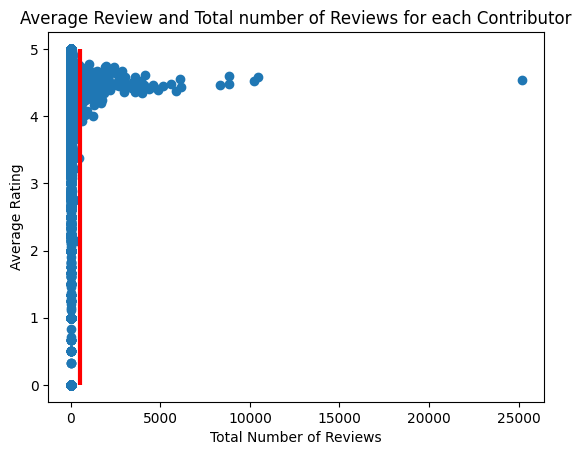

In [136]:
# Scatter plot of the average rating by the number of reviews for a contributor

rating_by_popularity = merged.groupby('contributor_id')['rating'].agg(['count','mean']).sort_values(by='count')
rating_by_popularity = rating_by_popularity.values
rating_by_popularity

plt.vlines(x=500,ymin=0,ymax=5,colors='red',linewidth=3)
scatter(rating_by_popularity[:,0],rating_by_popularity[:,1])
plt.title("Average Review and Total number of Reviews for each Contributor")
plt.ylabel("Average Rating")
plt.xlabel("Total Number of Reviews")
plt.savefig("total_reviews.png")

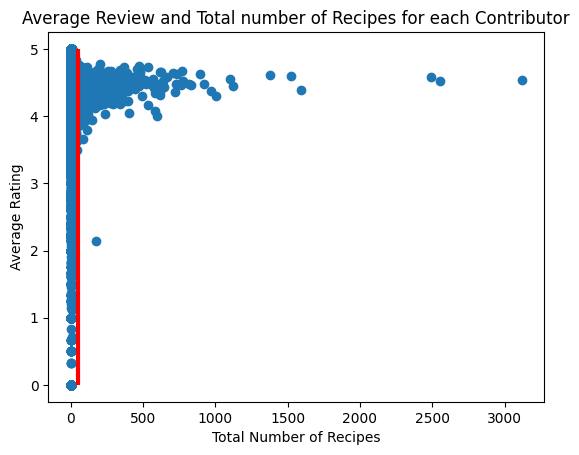

In [135]:

unique_recipe_contributors = recipes['contributor_id'].value_counts()
avg_rating_and_unique_recipes = pd.DataFrame(unique_recipe_contributors).merge(right=merged.groupby(['contributor_id'])['rating'].agg(['mean']),right_index=True,left_index=True)
# avg_rating_and_unique_recipes = avg_rating_and_unique_recipes[avg_rating_and_unique_recipes['count'] > 50]
plt.vlines(x=50,ymin=0,ymax=5,colors='red',linewidth=3)
scatter(x=avg_rating_and_unique_recipes.values[:,0],y=avg_rating_and_unique_recipes.values[:,1])
plt.title("Average Review and Total number of Recipes for each Contributor")
plt.ylabel("Average Rating")
plt.xlabel("Total Number of Recipes")
plt.savefig("total_recipes.png")

In [107]:
test = merged.groupby('contributor_id')['rating'].agg(['count','mean']).sort_values(by='count')
test = test[test['count'] > 500].index
merged['top_500_reviews'] = merged['user_id'].apply(lambda x: x in test)
top_50_recipes = avg_rating_and_unique_recipes[avg_rating_and_unique_recipes['count'] > 50].index 
merged['top_50_recipes'] = merged['user_id'].apply(lambda x: x in top_50_recipes)
final = merged.drop(columns=['date','contributor_id','submitted','tags','nutrition','ingredients'])
final

,user_id,recipe_id,rating,minutes,n_steps,n_ingredients,days_difference,top_500_reviews,top_50_recipes
0,38094,40893,4,495,4,9,149,False,False
1,1293707,40893,5,495,4,9,3378,False,False
2,8937,44394,4,20,5,4,35,False,False
3,126440,85009,5,10,3,13,2194,False,False
4,57222,85009,5,10,3,13,2775,False,True
...,...,...,...,...,...,...,...,...,...
905888,874900,83207,5,75,5,4,1938,False,False
905889,471652,83207,5,75,5,4,1941,False,False
905890,1160179,83207,5,75,5,4,1977,False,False
905891,923213,83207,5,75,5,4,2013,False,False


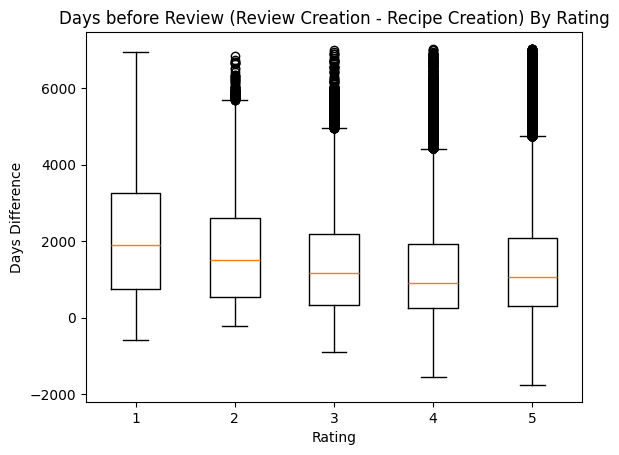

In [134]:
from matplotlib.pyplot import boxplot
days_diff_dict = {str(rating): final.days_difference[final.rating == rating].values for rating in range(1,6)}
days_diff_dict
fig, ax = plt.subplots()
boxplot(days_diff_dict.values())
ax.set_xticklabels(days_diff_dict.keys())
plt.title("Days before Review (Review Creation - Recipe Creation) By Rating")
plt.ylabel("Days Difference")
plt.xlabel("Rating")
plt.savefig("boxplot.png")

In [116]:
merged[['tags']].explode('tags')

,tags
0,"['weeknight', 'time-to-make', 'course', 'main-..."
1,"['weeknight', 'time-to-make', 'course', 'main-..."
2,"['30-minutes-or-less', 'time-to-make', 'course..."
3,"['15-minutes-or-less', 'time-to-make', 'course..."
4,"['15-minutes-or-less', 'time-to-make', 'course..."
...,...
905888,"['time-to-make', 'course', 'main-ingredient', ..."
905889,"['time-to-make', 'course', 'main-ingredient', ..."
905890,"['time-to-make', 'course', 'main-ingredient', ..."
905891,"['time-to-make', 'course', 'main-ingredient', ..."
